In [1]:
from google.colab import files
import io
import pandas as pd

uploaded = files.upload()

dataframe = pd.read_excel(io.BytesIO(uploaded['data2.xlsx']))

Saving data2.xlsx to data2.xlsx


Epoch 1/500
15/15 - 8s - loss: 0.1314 - val_loss: 0.0174 - 8s/epoch - 513ms/step
Epoch 2/500
15/15 - 0s - loss: 0.0279 - val_loss: 0.0429 - 114ms/epoch - 8ms/step
Epoch 3/500
15/15 - 0s - loss: 0.0145 - val_loss: 0.0198 - 134ms/epoch - 9ms/step
Epoch 4/500
15/15 - 0s - loss: 0.0099 - val_loss: 0.0209 - 124ms/epoch - 8ms/step
Epoch 5/500
15/15 - 0s - loss: 0.0089 - val_loss: 0.0184 - 127ms/epoch - 8ms/step
Epoch 6/500
15/15 - 0s - loss: 0.0082 - val_loss: 0.0185 - 118ms/epoch - 8ms/step
Epoch 7/500
15/15 - 0s - loss: 0.0077 - val_loss: 0.0166 - 113ms/epoch - 8ms/step
Epoch 8/500
15/15 - 0s - loss: 0.0074 - val_loss: 0.0156 - 135ms/epoch - 9ms/step
Epoch 9/500
15/15 - 0s - loss: 0.0064 - val_loss: 0.0148 - 119ms/epoch - 8ms/step
Epoch 10/500
15/15 - 0s - loss: 0.0058 - val_loss: 0.0159 - 117ms/epoch - 8ms/step
Epoch 11/500
15/15 - 0s - loss: 0.0055 - val_loss: 0.0131 - 132ms/epoch - 9ms/step
Epoch 12/500
15/15 - 0s - loss: 0.0049 - val_loss: 0.0124 - 123ms/epoch - 8ms/step
Epoch 13/500
1

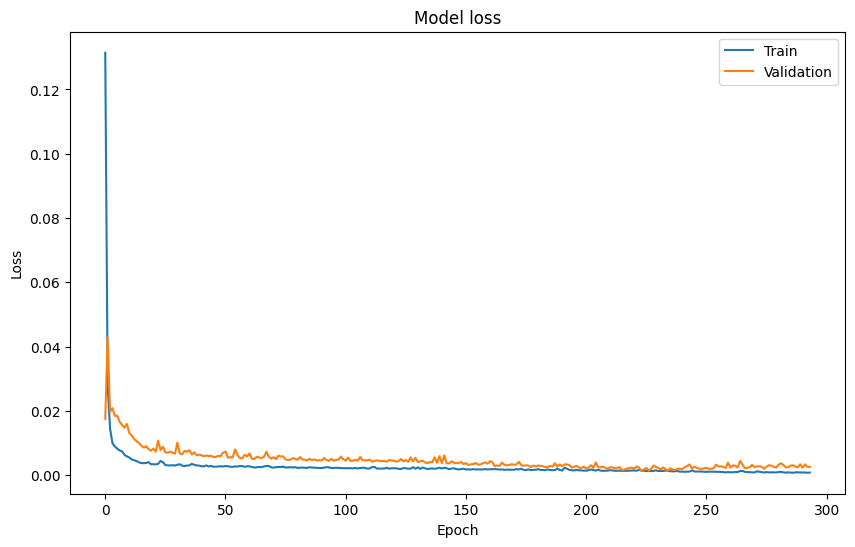

1/1 [==============================] - 0s 22ms/step


In [43]:
# Import necessary libraries
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

# Let's assume that the second column is the target and the rest are the features
# We exclude the first column (date)
data = dataframe.iloc[:, 1:].values

# Scale your data with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Prepare your data with some function, e.g., create_dataset
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]  # All columns including the target
        X.append(a)
        Y.append(dataset[i + look_back, 0])  # The target column
    return np.array(X), np.array(Y)

# Create the dataset
look_back = 3  # Number of previous time steps to use as input variables to predict the next time period
x, y = create_dataset(data, look_back)

# Determine the number of time periods to allocate as the test set (24 months for 2 years)
test_periods = 12

# Calculate the index to split the data
split_index = len(x) - test_periods

# Split the data into train and test sets
x_train, x_test = x[:split_index, :], x[split_index:, :]
y_train, y_test = y[:split_index], y[split_index:]


# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

# Initialize the RNN model
model = Sequential()

# Add GRU layers
model.add(GRU(30, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(GRU(30, return_sequences=True))

model.add(GRU(30))

# Add Dense layer with 1 unit
model.add(Dense(1))

# Compile the model with a custom learning rate
model.compile(optimizer=Adam(lr=0.000001), loss='mean_squared_error')


# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=70)

# Fit the model with the early stopping callback
history = model.fit(x_train, y_train, epochs=500, batch_size=16, verbose=2, validation_data=(x_test, y_test), callbacks=[early_stopping])

# Plot the loss for the training and validation set
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Make predictions
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [44]:
y_pred = model.predict(x_test)
print(y_pred)

1/1 [==============================] - 0s 30ms/step
[[0.63708234]
 [0.6900182 ]
 [0.72284764]
 [0.93226963]
 [0.9129764 ]
 [0.71123606]
 [0.6921078 ]
 [0.7325641 ]
 [0.94356287]
 [1.0531012 ]
 [0.750976  ]
 [0.7927257 ]]


In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
# 평균 제곱근 오차(RMSE) 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

# 평균 절대 오차(MAE) 계산
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE:", mape)

RMSE: 0.05026946979050651
MAE: 0.043931284336543246
MAPE: 0.053038569923986895


In [46]:
from sklearn.metrics import r2_score

# 결정 계수를 계산합니다.
r2 = r2_score(y_test, y_pred)

# 결정 계수를 출력합니다.
print("R^2 Score:", r2)

R^2 Score: 0.8164857316614778


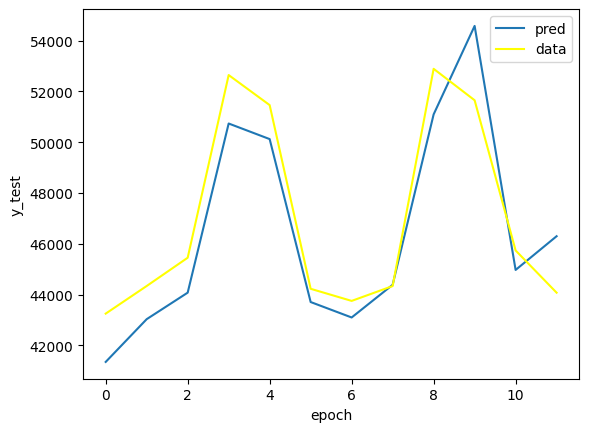

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

y_pred_or = y_pred*(52889.45221-21099.635)+21099.635
y_test_or = y_test*(52889.45221-21099.635)+21099.635
plt.plot(y_pred_or, label='pred')
plt.plot(y_test_or, label='data',color = 'yellow')
plt.ylabel('y_test')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

In [49]:
y_pred_or = y_pred*(52889.45221-21099.635)+21099.635
y_test_or = y_test*(52889.45221-21099.635)+21099.635
print(y_pred_or)
print(y_test_or)

[[41352.367]
 [43035.188]
 [44078.83 ]
 [50736.312]
 [50122.984]
 [43709.7  ]
 [43101.617]
 [44387.71 ]
 [51095.324]
 [54577.53 ]
 [44973.023]
 [46300.24 ]]
[43253.54509 44340.78814 45453.43341 52643.66332 51461.29845 44230.74019
 43753.94057 44338.6556  52889.45221 51651.5616  45739.50828 44077.47262]
